# BB Edital

## 1.136.1.16.4 Detecção, reconhecimento e tracking de múltiplas pessoas e objetos de interesse nos vídeos previamente gravados ou em tempo real.

## Install Python Requirements

Install Python packages from pypi.org.
We're pinning versions here to what was last tested.
You might want to comment these out after you have the packages, or update the versions if you
want to try the latest.

In [1]:
!pip install request
!pip install pandas
!pip install urllib3
!pip install CMake
!pip install imutils
!pip install numpy==1.18.4
!pip install opencv-contrib-python==4.1.2.30
!pip install opencv-python==4.1.2.30
!pip install scipy==1.4.1

ERROR: Could not find a version that satisfies the requirement request (from versions: none)
ERROR: No matching distribution found for request
     |████████████████████████████████| 19.8 MB 11.2 MB/s eta 0:00:01
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=21907b8096f03898a5698422fe6868847f332e43847465e3e0c14423074900c2
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/59/1b/52/0dea905f8278d5514dc4d0be5e251967f8681670cadd3dca89
Successfully built imutils
     |████████████████████████████████| 20.7 MB 10.6 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.2
    Uninstalling numpy-1.19.2:
      Successfully uninstalled numpy-1.19.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sparkmagic 0.18.0 requires nose, which is not installed.
hdijupyterutils 0.18.0 requires jupyter>=1

In [2]:
!pip install --upgrade pip
!pip install mmcv
!pip uninstall opencv-python opencv-python-headless -y

     |████████████████████████████████| 1.6 MB 24.8 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 21.1.2
    Uninstalling pip-21.1.2:
      Successfully uninstalled pip-21.1.2
     |████████████████████████████████| 307 kB 19.7 MB/s eta 0:00:01
     |████████████████████████████████| 185 kB 30.3 MB/s eta 0:00:01
  Created wheel for mmcv: filename=mmcv-1.3.11-py2.py3-none-any.whl size=449649 sha256=d2401db334dc7ca1781acfa834eb958182fcacecfa7f9d7767dc2b4a1658d368
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/d8/09/af/73dec705cab3b74d85c19cc4f77238f6ab2cc1ff6e82b6e062
Successfully built mmcv
Found existing installation: opencv-python 4.1.2.30
Uninstalling opencv-python-4.1.2.30:
  Successfully uninstalled opencv-python-4.1.2.30


In [3]:
!pip install ffmpeg-python

In [4]:
import json
import glob
import math
import os
import shutil
import cv2
import matplotlib.pyplot as plt
import numpy as np
import argparse
import time

from IPython.display import clear_output, Image, display
import requests
from collections import defaultdict


%matplotlib notebook

## Initial Configuration

In [5]:
CLEAN = False  # USE WITH CARE! Wipe out saved files when this is true (else reuse for speed)
input_video_url = "https://raw.githubusercontent.com/IBM/powerai-counting-cars/master/data/test_video.mp4"  # The input video
START_LINE = 0  # If start line is > 0, cars won't be added until below the line (try 200)
FRAMES_DIR = "frames"  # Output dir to hold/cache the original frames
OUTPUT_DIR = "output"  # Output dir to hold the annotated frames
SAMPLING = 10  # Classify every n frames (use tracking in between)
CONFIDENCE = 0.80  # Confidence threshold to filter iffy objects

# OpenCV colors are (B, G, R) tuples -- RGB in reverse
WHITE = (255, 255, 255)
YELLOW = (66, 244, 238)
GREEN = (80, 220, 60)
LIGHT_CYAN = (255, 255, 224)
DARK_BLUE = (139, 0, 0)
GRAY = (128, 128, 128)

## Download the video
This will download a small example video.


In [6]:
!wget {input_video_url}
input_video = input_video_url.split('/')[-1]

--2021-08-17 19:03:01--  https://raw.githubusercontent.com/IBM/powerai-counting-cars/master/data/test_video.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8887512 (8.5M) [application/octet-stream]
Saving to: ‘test_video.mp4’

test_video.mp4      100%[===================>]   8.48M  --.-KB/s    in 0.08s   

2021-08-17 19:03:01 (109 MB/s) - ‘test_video.mp4’ saved [8887512/8887512]



## Create or clean the directories
Caching the frames and output directories allows the processing to continue where it left off. This is particularly useful when using a shared system with deployment time limits. This also allows you to quickly `Run all` when tweaking Python code that does not affect the inference.

If you change the input video or just want a fresh start, you should `CLEAN` or change the directory names.

In [7]:
if CLEAN:
    if os.path.isdir(FRAMES_DIR):
        shutil.rmtree(FRAMES_DIR)
    if os.path.isdir(OUTPUT_DIR):
        shutil.rmtree(OUTPUT_DIR)

if not os.path.isdir(FRAMES_DIR):
    os.mkdir(FRAMES_DIR)
if not os.path.isdir(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)

## Parse and explode the video file into JPEGs
Each frame is saved as an individual JPEG file for later use.

In [8]:
if os.path.isfile(input_video):
    video_capture = cv2.VideoCapture(input_video)
else:
    raise Exception("File %s doesn't exist!" % input_video)

total_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
print("Frame count estimate is %d" % total_frames)

num = 0
while video_capture.get(cv2.CAP_PROP_POS_FRAMES) < video_capture.get(cv2.CAP_PROP_FRAME_COUNT):
    success, image = video_capture.read()
    if success:
        num = int(video_capture.get(cv2.CAP_PROP_POS_FRAMES))
        print("Writing frame {num} of {total_frames}".format(
            num=num, total_frames=total_frames), end="\r")
        cv2.imwrite('{frames_dir}/frame_{num:05d}.jpg'.format(
            frames_dir=FRAMES_DIR, num=num), image)
    else:
        # TODO: If this happens, we need to add retry code
        raise Exception('Error writing frame_{num:05d}.jpg'.format(
            num=int(video_capture.get(cv2.CAP_PROP_POS_FRAMES))))

print("\nWrote {num} frames".format(num=num))

FRAME_FPS = int(video_capture.get(cv2.CAP_PROP_FPS))
FRAME_WIDTH = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
FRAME_HEIGHT = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
ROI_YMAX = int(round(FRAME_HEIGHT * 0.75))  # Bottom quarter = finish line

print("Frame Dimensions: %sx%s" % (FRAME_WIDTH, FRAME_HEIGHT))

Frame count estimate is 1769
Writing frame 1769 of 1769
Wrote 1769 frames
Frame Dimensions: 960x540


In [9]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='dccd4310-ec4c-4655-9c86-318175838137', project_access_token='p-df846e5ff2cd263f175d05a3319cf08fdafb1bc9')
pc = project.project_context

In [10]:
#Função para lidar com arquivos compactados
import zipfile
def get_zip(nome_arquivo):
    '''
    nome_arquivo = nome do arquivo .zip que deseja baixar e extrair do Cloud Object Storage 
    '''
    try:
        fobj = open(nome_arquivo, "wb")
        fobj.write(project.get_file(nome_arquivo).read()) 
        fobj.close()
        z = zipfile.ZipFile(nome_arquivo)
        z.extractall()
    except Exception as e:
        print(Exception,e)
    else:
        print('Arquivos extraídos com sucesso') 

In [11]:
# Fetch the file
get_zip("yolo.zip")

Arquivos extraídos com sucesso


In [12]:
def plt_imshow(title, image):
  # convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

In [13]:
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
    "yolo": "yolo-object-detection/yolo-coco",
    "confidence": 0.85,
    "threshold": 0.7
}

In [14]:
# load the COCO class labels our YOLO model was trained on
labelsPath = os.path.sep.join([args["yolo"], "coco.names"])
LABELS = open(labelsPath).read().strip().split("\n")

# initialize a list of colors to represent each possible class label
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),
	dtype="uint8")

In [15]:
# derive the paths to the YOLO weights and model configuration
weightsPath = os.path.sep.join([args["yolo"], "yolov3.weights"])
configPath = os.path.sep.join([args["yolo"], "yolov3.cfg"])

# load our YOLO object detector trained on COCO dataset (80 classes)
print("[INFO] loading YOLO from disk...")
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

[INFO] loading YOLO from disk...


## DNN inference wrapper


In [16]:
def detect_objects(filename):
    
    # initialize our lists of detected bounding boxes, confidences, and
    # class IDs, respectively
    boxes = []
    confidences = []
    classIDs = []
    coordinates_changes = []
    results = []
    
    # load our input image and grab its spatial dimensions
    image = cv2.imread(filename)
    (H, W) = image.shape[:2]

    # determine only the *output* layer names that we need from YOLO
    ln = net.getLayerNames()
    ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    # construct a blob from the input image and then perform a forward
    # pass of the YOLO object detector, giving us our bounding boxes and
    # associated probabilities
    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (960, 540),
        swapRB=True, crop=False)
    net.setInput(blob)
    start = time.time()
    layerOutputs = net.forward(ln)
    end = time.time()
    
    
    # loop over each of the layer outputs
    for output in layerOutputs:
        # loop over each of the detections
        for detection in output:
            # extract the class ID and confidence (i.e., probability) of
            # the current object detection
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]

            # filter out weak predictions by ensuring the detected
            # probability is greater than the minimum probability
            if confidence > args["confidence"]:
                # scale the bounding box coordinates back relative to the
                # size of the image, keeping in mind that YOLO actually
                # returns the center (x, y)-coordinates of the bounding
                # box followed by the boxes' width and height
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")

                # use the center (x, y)-coordinates to derive the top and
                # and left corner of the bounding box
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))

                # update our list of bounding box coordinates, confidences,
                # and class IDs
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)
    # apply non-maxima suppression to suppress weak, overlapping bounding
    # boxes
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, args["confidence"],
                            args["threshold"])
    
    # ensure at least one detection exists
    if len(idxs) > 0:
        # loop over the indexes we are keeping
        for i in idxs.flatten():
            # extract the bounding box coordinates
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])
            # draw a bounding box rectangle and label on the image
            color = [int(c) for c in COLORS[classIDs[i]]]
            cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
            text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
            dataset = {"confidence": confidences[i], "ymax": y+h, "label": LABELS[classIDs[i]], "xmax": x+w, "xmin": x, "ymin": y, "attr": []}
            
            results.append(dataset)
             
            
            cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
                0.5, color, 2)
   
                                 
    result = json.dumps({"classified": results, "result": "success"}) 
                       
    plt_imshow("Image", image)
            
    return json.loads(result)

In [17]:
rc = detect_objects('frames/frame_00800.jpg')

<IPython.core.display.Javascript object>

## Test the API on a single frame


In [18]:
print("jsonresp: %s" % rc)
if 'classified' in rc:
    print("Got back %d objects" % len(rc['classified']))
print(json.dumps(rc, indent=2))

jsonresp: {'classified': [{'confidence': 0.9942341446876526, 'ymax': 485, 'label': 'car', 'xmax': 582, 'xmin': 419, 'ymin': 349, 'attr': []}, {'confidence': 0.9634652733802795, 'ymax': 179, 'label': 'car', 'xmax': 362, 'xmin': 292, 'ymin': 127, 'attr': []}, {'confidence': 0.92875075340271, 'ymax': 210, 'label': 'car', 'xmax': 529, 'xmin': 432, 'ymin': 129, 'attr': []}, {'confidence': 0.9197032451629639, 'ymax': 432, 'label': 'truck', 'xmax': 911, 'xmin': 719, 'ymin': 235, 'attr': []}, {'confidence': 0.9102514982223511, 'ymax': 269, 'label': 'car', 'xmax': 431, 'xmin': 307, 'ymin': 182, 'attr': []}, {'confidence': 0.8960150480270386, 'ymax': 182, 'label': 'car', 'xmax': 281, 'xmin': 234, 'ymin': 168, 'attr': []}], 'result': 'success'}
Got back 6 objects
{
  "classified": [
    {
      "confidence": 0.9942341446876526,
      "ymax": 485,
      "label": "car",
      "xmax": 582,
      "xmin": 419,
      "ymin": 349,
      "attr": []
    },
    {
      "confidence": 0.9634652733802795,
   

## Get object detection results for sampled frames
Since we've stored all video frames on disk (for easy reference), we can iterate over those files
and make queries as appropriate to Maximo Visual Inspection's API. We'll store the results in a
`tracking_results` dictionary, organized by file name. Since we are tracking objects from frame
to frame, we can use sampling to decide how often to check for new objects.

We're also caching the results so that you can change later code and run the notebook over
without running the same inference over again.

In [19]:
# Serialize requests, storing them in a "tracking_results" dict

try:
    with open('frames/frame-data-newmodel.json') as existing_results:
        tracking_results = json.load(existing_results)
except Exception:
    # Any fail to read existing results means we start over
    tracking_results = {}

print("Sampling every %sth frame" % SAMPLING)
i = 0
cache_used = 0
sampled = 0
for filename in sorted(glob.glob('frames/frame_*.jpg')):
    i += 1

    if not i % SAMPLING == 0:  # Sample every Nth
        continue

    existing_result = tracking_results.get(filename)
    #if existing_result and existing_result['result'] == 'success':
    cache_used += 1
    #else:
    results = detect_objects(filename)
    sampled += 1
    # Save frequently to cache partial results
    tracking_results[filename] = results
    with open('frames/frame-data-newmodel.json', 'w') as fp:
        json.dump(tracking_results, fp)

    print("Processed file {num} of {total_frames} (used cache {cache_used} times)".format(
        num=i, total_frames=total_frames, cache_used=cache_used), end="\r")

# Finally, write all our results
with open('frames/frame-data-newmodel.json', 'w') as fp:
    json.dump(tracking_results, fp)

print("\nDone")


Sampling every 10th frame
Processed file 1760 of 1769 (used cache 176 times)
Done


In [20]:
tracking_results

{'frames/frame_00010.jpg': {'classified': [{'confidence': 0.9975550174713135,
    'ymax': 269,
    'label': 'car',
    'xmax': 631,
    'xmin': 505,
    'ymin': 163,
    'attr': []},
   {'confidence': 0.9931017756462097,
    'ymax': 269,
    'label': 'car',
    'xmax': 401,
    'xmin': 297,
    'ymin': 170,
    'attr': []},
   {'confidence': 0.979042649269104,
    'ymax': 223,
    'label': 'car',
    'xmax': 337,
    'xmin': 246,
    'ymin': 150,
    'attr': []},
   {'confidence': 0.9665777683258057,
    'ymax': 214,
    'label': 'car',
    'xmax': 503,
    'xmin': 410,
    'ymin': 134,
    'attr': []},
   {'confidence': 0.9004054665565491,
    'ymax': 178,
    'label': 'car',
    'xmax': 284,
    'xmin': 233,
    'ymin': 143,
    'attr': []},
   {'confidence': 0.8678944110870361,
    'ymax': 209,
    'label': 'car',
    'xmax': 496,
    'xmin': 418,
    'ymin': 144,
    'attr': []}],
  'result': 'success'},
 'frames/frame_00020.jpg': {'classified': [{'confidence': 0.9968952536582947,


## Define helper functions for tracking and drawing labels

In [21]:
def label_object(color, textcolor, fontface, image, car, textsize, thickness, xmax, xmid, xmin, ymax, ymid, ymin):
    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, thickness)
    pos = (xmid - textsize[0]//2, ymid + textsize[1]//2)
    cv2.putText(image, car, pos, fontface, 1, textcolor, thickness, cv2.LINE_AA)


def update_trackers(image, counters):
    left_lane = counters['left_lane']
    right_lane = counters['right_lane']
    boxes = []
    color = (80, 220, 60)
    fontface = cv2.FONT_HERSHEY_SIMPLEX
    fontscale = 1
    thickness = 1

    for n, pair in enumerate(trackers):
        tracker, car = pair
        textsize, _baseline = cv2.getTextSize(
            car, fontface, fontscale, thickness)
        success, bbox = tracker.update(image)

        if not success:
            counters['lost_trackers'] += 1
            del trackers[n]
            continue

        boxes.append(bbox)  # Return updated box list

        xmin = int(bbox[0])
        ymin = int(bbox[1])
        xmax = int(bbox[0] + bbox[2])
        ymax = int(bbox[1] + bbox[3])
        xmid = int(round((xmin+xmax)/2))
        ymid = int(round((ymin+ymax)/2))

        if ymid >= ROI_YMAX:
            label_object(WHITE, WHITE, fontface, image, car, textsize, 1, xmax, xmid, xmin, ymax, ymid, ymin)
            # Count left-lane, right-lane as cars ymid crosses finish line
            if xmid < 630:
                left_lane += 1
            else:
                right_lane += 1
            # Stop tracking cars when they hit finish line
            del trackers[n]
        else:
            # Rectangle and number on the cars we are tracking
            label_object(color, YELLOW, fontface, image, car, textsize, 4, xmax, xmid, xmin, ymax, ymid, ymin)

    # Add finish line overlay/line
    overlay = image.copy()

    # Shade region of interest (ROI). We're really just using the top line.
    cv2.rectangle(overlay,
                  (0, ROI_YMAX),
                  (FRAME_WIDTH, FRAME_HEIGHT), DARK_BLUE, cv2.FILLED)
    cv2.addWeighted(overlay, 0.6, image, 0.4, 0, image)

    # Draw start line, if > 0
    if START_LINE > 0:
        cv2.line(image, (0, START_LINE), (FRAME_WIDTH, START_LINE), GRAY, 4, cv2.LINE_AA)
    # Draw finish line with lane hash marks
    cv2.line(image, (0, ROI_YMAX), (FRAME_WIDTH, ROI_YMAX), LIGHT_CYAN, 4, cv2.LINE_AA)
    cv2.line(image, (350, ROI_YMAX - 20), (350, ROI_YMAX + 20), LIGHT_CYAN, 4, cv2.LINE_AA)
    cv2.line(image, (630, ROI_YMAX - 20), (630, ROI_YMAX + 20), LIGHT_CYAN, 4, cv2.LINE_AA)
    cv2.line(image, (950, ROI_YMAX - 20), (950, ROI_YMAX + 20), LIGHT_CYAN, 4, cv2.LINE_AA)

    # Add lane counter
    cv2.putText(image, "Lane counter:", (30, ROI_YMAX + 80), fontface, 1.5, LIGHT_CYAN, 4, cv2.LINE_AA)
    cv2.putText(image, str(left_lane), (480, ROI_YMAX + 80), fontface, 1.5, LIGHT_CYAN, 4, cv2.LINE_AA)
    cv2.putText(image, str(right_lane), (800, ROI_YMAX + 80), fontface, 1.5, LIGHT_CYAN, 4, cv2.LINE_AA)
    seconds = counters['frames'] / FRAME_FPS
    cv2.putText(image, "Cars/second:", (35, ROI_YMAX + 110), fontface, 0.5, LIGHT_CYAN, 1, cv2.LINE_AA)
    cv2.putText(image, '{0:.2f}'.format(left_lane / seconds), (480, ROI_YMAX + 110), fontface, 0.5, LIGHT_CYAN, 1, cv2.LINE_AA)
    cv2.putText(image, '{0:.2f}'.format(right_lane / seconds), (800, ROI_YMAX + 110), fontface, 0.5, LIGHT_CYAN, 1, cv2.LINE_AA)

    counters['left_lane'] = left_lane
    counters['right_lane'] = right_lane
    return boxes, counters


In [22]:
def not_tracked(objects, boxes):
    if not objects:
        return []  # No new classified objects to search for
    if not boxes:
        return objects  # No existing boxes, return all objects

    new_objects = []
    for obj in objects:
        ymin = obj['ymin']
        ymax = obj['ymax']
        ymid = int(round((ymin+ymax)/2))
        xmin = obj['xmin']
        xmax = obj['xmax']
        xmid = int(round((xmin+xmax)/2))
        box_range = ((xmax - xmin) + (ymax - ymin)) / 2
        for bbox in boxes:
            bxmin = int(bbox[0])
            bymin = int(bbox[1])
            bxmax = int(bbox[0] + bbox[2])
            bymax = int(bbox[1] + bbox[3])
            bxmid = int((bxmin + bxmax) / 2)
            bymid = int((bymin + bymax) / 2)
            if math.sqrt((xmid - bxmid)**2 + (ymid - bymid)**2) < box_range:
                # found existing, so break (do not add to new_objects)
                break
        else:
            new_objects.append(obj)

    return new_objects


In [23]:
def in_range(obj):
    ymin = obj['ymin']
    ymax = obj['ymax']
    if ymin < START_LINE or ymax > ROI_YMAX:
        # Don't add new trackers before start or after finish.
        # Start line can help avoid overlaps and tracker loss.
        # Finish line protection avoids counting the car twice.
        return False
    return True
    
def add_new_object(obj, image, cars):
    car = str(cars)
    xmin = obj['xmin']
    xmax = obj['xmax']
    ymin = obj['ymin']
    ymax = obj['ymax']
    xmid = int(round((xmin+xmax)/2))
    ymid = int(round((ymin+ymax)/2))
    fontface = cv2.FONT_HERSHEY_SIMPLEX
    fontscale = 1
    thickness = 1
    textsize, _baseline = cv2.getTextSize(
        car, fontface, fontscale, thickness)

    # init tracker
    tracker = cv2.TrackerKCF_create()  # Note: Try comparing KCF with MIL
    success = tracker.init(image, (xmin, ymin, xmax-xmin, ymax-ymin))
    if success:
        trackers.append((tracker, car))

    label_object(GREEN, YELLOW, fontface, image, car, textsize, 4, xmax, xmid, xmin, ymax, ymid, ymin)


## Inference, tracking, and annotation
Loop through the saved frames and:
1. Update the trackers to follow already detected objects from frame to frame.
1. Look for new objects if we ran inference on this frame.
    * Check for overlap with tracked objects.
    * If no overlap, assign a sequence number and start tracking.
1. Write an annotated image with tracked objects highlighted and numbered.

In [24]:
cars = 0
trackers = []
counters = {
    'left_lane':  0,
    'right_lane':  0,
    'lost_trackers': 0,
    'frames': 0,
}

with open('frames/frame-data-newmodel.json') as existing_results:
    tracking_results = json.load(existing_results)

for filename in sorted(glob.glob('frames/frame_*.jpg')):
    counters['frames'] += 1
    img = cv2.imread(filename)
    boxes, counters = update_trackers(img, counters)

    if filename in tracking_results and 'classified' in tracking_results[filename]:
        jsonresp = tracking_results[filename]
        for obj in not_tracked(jsonresp['classified'], boxes):
            if in_range(obj):
                cars += 1
                add_new_object(obj, img, cars)  # Label and start tracking

    # Draw the running total of cars in the image in the upper-left corner
    cv2.putText(img, 'Cars detected: ' + str(cars), (30, 60),
                cv2.FONT_HERSHEY_SIMPLEX, 1.5, DARK_BLUE, 4, cv2.LINE_AA)
    # Add note with count of trackers lost
    cv2.putText(img, 'Cars lost: ' + str(counters['lost_trackers']), (35, 85),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, DARK_BLUE, 1, cv2.LINE_AA)

    cv2.imwrite("output/output-" + filename.split('/')[1], img)
    print("Processed file {num} of {total_frames}".format(
        num=counters['frames'], total_frames=total_frames), end="\r")

print("\nDone")


Processed file 1769 of 1769
Done


## Play the annotated frames in the notebook

This code will play the annotated frames in a loop to demonstrate the new video.
Running this in the notebook is usually slow. Shrinking the size helps some.
Refer to the following section to build a real, full speed video.

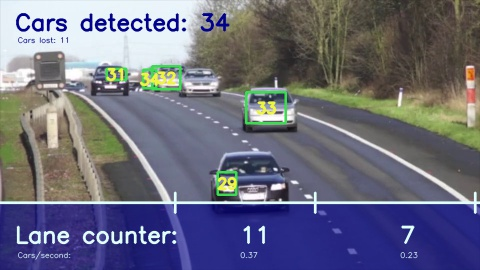

In [25]:
for filename in sorted(glob.glob(os.path.join(os.path.abspath(OUTPUT_DIR),
                                              'output-frame_*.jpg'))):
    frame = cv2.imread(filename)
    clear_output(wait=True)
    rows, columns, _channels = frame.shape
    frame = cv2.resize(frame, (int(columns/2), int(rows/2)))  # shrink it
    _ret, jpg = cv2.imencode('.jpg', frame)
    display(Image(data=jpg))

## Create a video from the annotated frames

This command requires `ffmpeg`. It will combine the annotated
frames to build an MP4 video which you can play at full speed
(the notebook playback above was most likely slow).

Uncomment the command to try running it from this notebook, or
copy the output files to a system with `ffmpeg` and run the
command there.

> NOTE: The command below requires libx264 for encoding video
stream into the H.264/MPEG-4 AVC compression format. Please 
check that `ffmpeg` was configured and built with `--enable-libx264`
(`ffmpeg 2>&1 | grep libx264`).
If not, just remove the `-vcodec libx264` option from the
following command.

In [26]:
!ffmpeg -y -r 60 -f image2 -i output/output-frame_%05d.jpg -vcodec libx264 -crf 25  -pix_fmt yuvj420p novo.mp4

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda/envs/Python-3.8-CUDA --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55

In [27]:
from IPython.display import HTML
from base64 import b64encode

mp4 = open("novo.mp4", "rb").read()
dataURL = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=800 controls>
      <source src="%s" type="video/mp4">
</video>
""" % dataURL)

### Deploy

In [2]:
cred = {
    'IAM_SERVICE_ID': 'iam-ServiceId-00158728-ce50-484b-9a6a-d52215f8f3ae',
    'IBM_API_KEY_ID': 'yTEoj_YWhgwBqcLtvyT-U3lero-gJdONuLKypkYInUvw',
    'ENDPOINT': 'https://s3.private.us.cloud-object-storage.appdomain.cloud',
    'IBM_AUTH_ENDPOINT': 'https://iam.cloud.ibm.com/oidc/token',
    'BUCKET': 'bbedital-donotdelete-pr-nsdnczordihncx',
    'FILE': 'yolo.zip'
}

In [3]:
output = {
  "apikey": "KUBxsnRbABz5zWTjV_CGtt9VQOyu0h1H6fvZa-93w__m",
  "endpoints": "https://control.cloud-object-storage.cloud.ibm.com/v2/endpoints",
  "iam_apikey_description": "Auto-generated for key 6051c404-10a5-4bc0-a1be-3bd229a2ee0b",
  "iam_apikey_name": "Service credentials-1",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/6947af62e3b04a72b2841c77876de404::serviceid:ServiceId-0c9fed1c-84e2-4603-8f24-b18213937f25",
  "resource_instance_id": "crn:v1:bluemix:public:cloud-object-storage:global:a/6947af62e3b04a72b2841c77876de404:c4ac5b58-7e51-4853-8898-f8796759aec4::",
  'BUCKET': 'rowml-f02aa181-a165-4d73-bcfa-385005832707',
  'ENDPOINT': 'https://s3.us.cloud-object-storage.appdomain.cloud'
}

In [4]:
args_f = {
    "yolo": "yolo-object-detection/yolo-coco",
    "confidence": 0.85,
    "threshold": 0.7
}

In [5]:
def tracking(credentials_cos=cred, out=output, args=args_f):
    
    try:
        
        import subprocess
        subprocess.check_output("pip install pandas --user", stderr=subprocess.STDOUT, shell=True)
        subprocess.check_output("pip install urllib3 --user", stderr=subprocess.STDOUT, shell=True)
        subprocess.check_output("pip install CMake --user", stderr=subprocess.STDOUT, shell=True)
        subprocess.check_output("pip install imutils --user", stderr=subprocess.STDOUT, shell=True)
        subprocess.check_output("pip install numpy==1.18.4 --user", stderr=subprocess.STDOUT, shell=True)
        subprocess.check_output("pip install opencv-contrib-python-headless --user", stderr=subprocess.STDOUT, shell=True)
        subprocess.check_output("pip install scipy==1.4.1 --user", stderr=subprocess.STDOUT, shell=True)
        subprocess.check_output("pip install --upgrade pip --user", stderr=subprocess.STDOUT, shell=True)
        subprocess.check_output("pip install mmcv --user", stderr=subprocess.STDOUT, shell=True)
        subprocess.check_output("pip install ffmpeg-python --user", stderr=subprocess.STDOUT, shell=True)
        
    except subprocess.CalledProcessError as e:        
        install_err = "subprocess.CalledProcessError:\n\n" + "cmd:\n" + e.cmd + "\n\noutput:\n" + e.output.decode()
        raise Exception("Installing failed:\n" + install_err)
        
    import numpy as np
    import imutils
    import cv2
    import os
    import ibm_boto3
    from ibm_botocore.client import Config
    import zipfile
    import glob
    import json
    import math
    import shutil
        
    try:
        CLEAN = False
        START_LINE = 0  # If start line is > 0, cars won't be added until below the line (try 200)
        FRAMES_DIR = "frames"  # Output dir to hold/cache the original frames
        OUTPUT_DIR = "output"  # Output dir to hold the annotated frames
        SAMPLING = 10  # Classify every n frames (use tracking in between)
        CONFIDENCE = 0.80  # Confidence threshold to filter iffy objects

        # OpenCV colors are (B, G, R) tuples -- RGB in reverse
        WHITE = (255, 255, 255)
        YELLOW = (66, 244, 238)
        GREEN = (80, 220, 60)
        LIGHT_CYAN = (255, 255, 224)
        DARK_BLUE = (139, 0, 0)
        GRAY = (128, 128, 128)
        cos = ibm_boto3.client("s3",
                ibm_api_key_id=credentials_cos['IBM_API_KEY_ID'],
                ibm_service_instance_id=credentials_cos['IBM_API_KEY_ID'],
                config=Config(signature_version="oauth"),
                endpoint_url=credentials_cos['ENDPOINT']
        )
        res=cos.get_object(Bucket=credentials_cos['BUCKET'], Key=credentials_cos['FILE'])
        with open(credentials_cos['FILE'], 'wb') as f:
            f.write(res['Body'].read())
        z = zipfile.ZipFile(credentials_cos['FILE'])
        z.extractall()
    except Exception as e:
        raise Exception("Not able to get yolo") 
        
    def detect_objects(filename, net, COLORS, LABELS):
        boxes = []
        confidences = []
        classIDs = []
        coordinates_changes = []
        results = []
        image = cv2.imread(filename)
        (H, W) = image.shape[:2]
        ln = net.getLayerNames()
        ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
        blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (960, 540), swapRB=True, crop=False)
        net.setInput(blob)
        layerOutputs = net.forward(ln)
        for output in layerOutputs:
            for detection in output:
                scores = detection[5:]
                classID = np.argmax(scores)
                confidence = scores[classID]
                if confidence > args["confidence"]:
                    box = detection[0:4] * np.array([W, H, W, H])
                    (centerX, centerY, width, height) = box.astype("int")
                    x = int(centerX - (width / 2))
                    y = int(centerY - (height / 2))
                    boxes.append([x, y, int(width), int(height)])
                    confidences.append(float(confidence))
                    classIDs.append(classID)
        idxs = cv2.dnn.NMSBoxes(boxes, confidences, args["confidence"], args["threshold"])
        if len(idxs) > 0:
            for i in idxs.flatten():
                (x, y) = (boxes[i][0], boxes[i][1])
                (w, h) = (boxes[i][2], boxes[i][3])
                color = [int(c) for c in COLORS[classIDs[i]]]
                cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
                text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
                dataset = {"confidence": confidences[i], "ymax": y+h, "label": LABELS[classIDs[i]], "xmax": x+w, "xmin": x, "ymin": y, "attr": []}
                results.append(dataset)
                cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        result = json.dumps({"classified": results, "result": "success"}) 
        return json.loads(result)
    
    def label_object(color, textcolor, fontface, image, car, textsize, thickness, xmax, xmid, xmin, ymax, ymid, ymin):
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, thickness)
        pos = (xmid - textsize[0]//2, ymid + textsize[1]//2)
        cv2.putText(image, car, pos, fontface, 1, textcolor, thickness, cv2.LINE_AA)


    def update_trackers(image, counters, trackers, ROI_YMAX, FRAME_WIDTH, FRAME_HEIGHT, FRAME_FPS):
        left_lane = counters['left_lane']
        right_lane = counters['right_lane']
        boxes = []
        color = (80, 220, 60)
        fontface = cv2.FONT_HERSHEY_SIMPLEX
        fontscale = 1
        thickness = 1

        for n, pair in enumerate(trackers):
            tracker, car = pair
            textsize, _baseline = cv2.getTextSize(
                car, fontface, fontscale, thickness)
            success, bbox = tracker.update(image)

            if not success:
                counters['lost_trackers'] += 1
                del trackers[n]
                continue

            boxes.append(bbox)  # Return updated box list

            xmin = int(bbox[0])
            ymin = int(bbox[1])
            xmax = int(bbox[0] + bbox[2])
            ymax = int(bbox[1] + bbox[3])
            xmid = int(round((xmin+xmax)/2))
            ymid = int(round((ymin+ymax)/2))

            if ymid >= ROI_YMAX:
                label_object(WHITE, WHITE, fontface, image, car, textsize, 1, xmax, xmid, xmin, ymax, ymid, ymin)
                # Count left-lane, right-lane as cars ymid crosses finish line
                if xmid < 630:
                    left_lane += 1
                else:
                    right_lane += 1
                # Stop tracking cars when they hit finish line
                del trackers[n]
            else:
                # Rectangle and number on the cars we are tracking
                label_object(color, YELLOW, fontface, image, car, textsize, 4, xmax, xmid, xmin, ymax, ymid, ymin)

        # Add finish line overlay/line
        overlay = image.copy()

        # Shade region of interest (ROI). We're really just using the top line.
        cv2.rectangle(overlay,
                      (0, ROI_YMAX),
                      (FRAME_WIDTH, FRAME_HEIGHT), DARK_BLUE, cv2.FILLED)
        cv2.addWeighted(overlay, 0.6, image, 0.4, 0, image)

        # Draw start line, if > 0
        if START_LINE > 0:
            cv2.line(image, (0, START_LINE), (FRAME_WIDTH, START_LINE), GRAY, 4, cv2.LINE_AA)
        # Draw finish line with lane hash marks
        cv2.line(image, (0, ROI_YMAX), (FRAME_WIDTH, ROI_YMAX), LIGHT_CYAN, 4, cv2.LINE_AA)
        cv2.line(image, (350, ROI_YMAX - 20), (350, ROI_YMAX + 20), LIGHT_CYAN, 4, cv2.LINE_AA)
        cv2.line(image, (630, ROI_YMAX - 20), (630, ROI_YMAX + 20), LIGHT_CYAN, 4, cv2.LINE_AA)
        cv2.line(image, (950, ROI_YMAX - 20), (950, ROI_YMAX + 20), LIGHT_CYAN, 4, cv2.LINE_AA)

        # Add lane counter
        cv2.putText(image, "Lane counter:", (30, ROI_YMAX + 80), fontface, 1.5, LIGHT_CYAN, 4, cv2.LINE_AA)
        cv2.putText(image, str(left_lane), (480, ROI_YMAX + 80), fontface, 1.5, LIGHT_CYAN, 4, cv2.LINE_AA)
        cv2.putText(image, str(right_lane), (800, ROI_YMAX + 80), fontface, 1.5, LIGHT_CYAN, 4, cv2.LINE_AA)
        seconds = counters['frames'] / FRAME_FPS
        cv2.putText(image, "Cars/second:", (35, ROI_YMAX + 110), fontface, 0.5, LIGHT_CYAN, 1, cv2.LINE_AA)
        cv2.putText(image, '{0:.2f}'.format(left_lane / seconds), (480, ROI_YMAX + 110), fontface, 0.5, LIGHT_CYAN, 1, cv2.LINE_AA)
        cv2.putText(image, '{0:.2f}'.format(right_lane / seconds), (800, ROI_YMAX + 110), fontface, 0.5, LIGHT_CYAN, 1, cv2.LINE_AA)

        counters['left_lane'] = left_lane
        counters['right_lane'] = right_lane
        return boxes, counters
    
    def not_tracked(objects, boxes):
        if not objects:
            return []  # No new classified objects to search for
        if not boxes:
            return objects  # No existing boxes, return all objects

        new_objects = []
        for obj in objects:
            ymin = obj['ymin']
            ymax = obj['ymax']
            ymid = int(round((ymin+ymax)/2))
            xmin = obj['xmin']
            xmax = obj['xmax']
            xmid = int(round((xmin+xmax)/2))
            box_range = ((xmax - xmin) + (ymax - ymin)) / 2
            for bbox in boxes:
                bxmin = int(bbox[0])
                bymin = int(bbox[1])
                bxmax = int(bbox[0] + bbox[2])
                bymax = int(bbox[1] + bbox[3])
                bxmid = int((bxmin + bxmax) / 2)
                bymid = int((bymin + bymax) / 2)
                if math.sqrt((xmid - bxmid)**2 + (ymid - bymid)**2) < box_range:
                    # found existing, so break (do not add to new_objects)
                    break
            else:
                new_objects.append(obj)

        return new_objects
    
    def in_range(obj, ROI_YMAX):
        ymin = obj['ymin']
        ymax = obj['ymax']
        if ymin < START_LINE or ymax > ROI_YMAX:
            # Don't add new trackers before start or after finish.
            # Start line can help avoid overlaps and tracker loss.
            # Finish line protection avoids counting the car twice.
            return False
        return True

    def add_new_object(obj, image, cars, trackers):
        car = str(cars)
        xmin = obj['xmin']
        xmax = obj['xmax']
        ymin = obj['ymin']
        ymax = obj['ymax']
        xmid = int(round((xmin+xmax)/2))
        ymid = int(round((ymin+ymax)/2))
        fontface = cv2.FONT_HERSHEY_SIMPLEX
        fontscale = 1
        thickness = 1
        textsize, _baseline = cv2.getTextSize(
            car, fontface, fontscale, thickness)

        # init tracker
        tracker = cv2.TrackerKCF_create()  # Note: Try comparing KCF with MIL
        success = tracker.init(image, (xmin, ymin, xmax-xmin, ymax-ymin))
        if success:
            trackers.append((tracker, car))

        label_object(GREEN, YELLOW, fontface, image, car, textsize, 4, xmax, xmid, xmin, ymax, ymid, ymin)
        
    def score(function_payload):
        from PIL import Image
        import ffmpeg
            
        try:
            if CLEAN:
                if os.path.isdir(FRAMES_DIR):
                    shutil.rmtree(FRAMES_DIR)
                if os.path.isdir(OUTPUT_DIR):
                    shutil.rmtree(OUTPUT_DIR)

            if not os.path.isdir(FRAMES_DIR):
                os.mkdir(FRAMES_DIR)
            if not os.path.isdir(OUTPUT_DIR):
                os.mkdir(OUTPUT_DIR)
            cos_out = ibm_boto3.client("s3",
                ibm_api_key_id=out['apikey'],
                ibm_service_instance_id=out['resource_instance_id'],
                config=Config(signature_version="oauth"),
                endpoint_url=out['ENDPOINT']
            )
            
            labelsPath = os.path.sep.join([args["yolo"], "coco.names"])
            LABELS = open(labelsPath).read().strip().split("\n")
            np.random.seed(42)
            COLORS = np.random.randint(0, 255, size=(len(LABELS), 3), dtype="uint8")
            weightsPath = os.path.sep.join([args["yolo"], "yolov3.weights"])
            configPath = os.path.sep.join([args["yolo"], "yolov3.cfg"])
            net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)
            fl = function_payload['input_data'][0]['values'][0]['filename']
            res = cos_out.get_object(Bucket=out['BUCKET'], Key=fl)
            with open(fl, 'wb') as cos_video:
                cos_video.write(res['Body'].read())
            video_capture = cv2.VideoCapture(fl)
            num = 0
            while video_capture.get(cv2.CAP_PROP_POS_FRAMES) < video_capture.get(cv2.CAP_PROP_FRAME_COUNT):
                success, image = video_capture.read()
                if success:
                    num = int(video_capture.get(cv2.CAP_PROP_POS_FRAMES))
                    cv2.imwrite('{frames_dir}/frame_{num:05d}.jpg'.format(frames_dir='frames', num=num), image)
                    
            FRAME_FPS = int(video_capture.get(cv2.CAP_PROP_FPS))
            FRAME_WIDTH = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
            FRAME_HEIGHT = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
            ROI_YMAX = int(round(FRAME_HEIGHT * 0.75))  # Bottom quarter = finish line
            
            tracking_results = {}
                    
            try:
                with open('frames/frame-data-newmodel.json') as existing_results:
                    tracking_results = json.load(existing_results)
            except Exception as e:
                # Any fail to read existing results means we start over
                print("tracking Expction" + str(e))
                tracking_results = {}
                
            i = 0
            cache_used = 0
            sampled = 0
            for filename in sorted(glob.glob('frames/frame_*.jpg')):
                i += 1

                if not i % SAMPLING == 0:  # Sample every Nth
                    continue

                existing_result = tracking_results.get(filename)
                #if existing_result and existing_result['result'] == 'success':
                cache_used += 1
                #else:
                results = detect_objects(filename, net, COLORS, LABELS)
                sampled += 1
                # Save frequently to cache partial results
                tracking_results[filename] = results
                with open('frames/frame-data-newmodel.json', 'w') as fp:
                    json.dump(tracking_results, fp)

            # Finally, write all our results
            with open('frames/frame-data-newmodel.json', 'w') as fp:
                json.dump(tracking_results, fp)
                
            cars = 0
            trackers = []
            counters = {
                'left_lane':  0,
                'right_lane':  0,
                'lost_trackers': 0,
                'frames': 0,
            }

            with open('frames/frame-data-newmodel.json') as existing_results:
                tracking_results = json.load(existing_results)

            for filename in sorted(glob.glob('frames/frame_*.jpg')):
                counters['frames'] += 1
                img = cv2.imread(filename)
                boxes, counters = update_trackers(img, counters, trackers, ROI_YMAX, FRAME_WIDTH, FRAME_HEIGHT, FRAME_FPS)

                if filename in tracking_results and 'classified' in tracking_results[filename]:
                    jsonresp = tracking_results[filename]
                    for obj in not_tracked(jsonresp['classified'], boxes):
                        if in_range(obj, ROI_YMAX):
                            cars += 1
                            add_new_object(obj, img, cars, trackers)  # Label and start tracking

                # Draw the running total of cars in the image in the upper-left corner
                cv2.putText(img, 'Cars detected: ' + str(cars), (30, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.5, DARK_BLUE, 4, cv2.LINE_AA)
                cv2.putText(img, 'Cars lost: ' + str(counters['lost_trackers']), (35, 85), cv2.FONT_HERSHEY_SIMPLEX, 0.5, DARK_BLUE, 1, cv2.LINE_AA)

                cv2.imwrite("output/output-" + filename.split('/')[1], img)
            
#             for filename in sorted(glob.glob(os.path.join(os.path.abspath(OUTPUT_DIR), 'output-frame_*.jpg'))):
#                 frame = cv2.imread(filename)
# #                 clear_output(wait=True)
#                 rows, columns, _channels = frame.shape
#                 frame = cv2.resize(frame, (int(columns/2), int(rows/2)))  # shrink it
#                 _ret, jpg = cv2.imencode('.jpg', frame)
                
            frames_ff = [i for i in os.listdir('output/') if i.endswith('jpg')]
            with open('list.txt', 'w') as f:
                for i in range(len(frames_ff)):
                    f.write("file '{}/output/output-frame_{num:05d}.jpg'\n".format(os.getcwd(), num = i+1))
            ffmpeg.input("list.txt", r=60, f='concat', safe='0').output('out.mp4', pix_fmt='yuv420p', vcodec='libx264').run(overwrite_output=True)
            
            with open('out.mp4', 'rb') as output_video:
                cos_out.put_object(Body=output_video, Bucket=out["BUCKET"], Key="out.mp4")
            return {'predictions': [{'values': ['done', tracking_results]}]}
        
        except Exception as e:
            
            return {'predictions': [{'values': [repr(e)]}]}


    return score

In [32]:
import ibm_boto3
from ibm_botocore.client import Config

In [33]:
cos_out_local = ibm_boto3.client("s3",
    ibm_api_key_id=output['apikey'],
    ibm_service_instance_id=output['resource_instance_id'],
    config=Config(signature_version="oauth"),
    endpoint_url=output['ENDPOINT']
)

In [34]:
with open('test_video.mp4', 'rb') as video:
    cos_out_local.put_object(Body=video, Bucket=output["BUCKET"], Key="test.mp4")

In [35]:
input_data = { 
    "input_data":
    [
        {
            "values": [
                {
                    "filename": "test.mp4"
                }
            ]
        }
    ]
}

In [87]:
function_result = tracking()(input_data)
print(function_result)

frames/frame_00001.jpg
frames/frame_00002.jpg
frames/frame_00003.jpg
frames/frame_00004.jpg
frames/frame_00005.jpg
frames/frame_00006.jpg
frames/frame_00007.jpg
frames/frame_00008.jpg
frames/frame_00009.jpg
frames/frame_00010.jpg
frames/frame_00011.jpg
frames/frame_00012.jpg
frames/frame_00013.jpg
frames/frame_00014.jpg
frames/frame_00015.jpg
frames/frame_00016.jpg
frames/frame_00017.jpg
frames/frame_00018.jpg
frames/frame_00019.jpg
frames/frame_00020.jpg
frames/frame_00021.jpg
frames/frame_00022.jpg
frames/frame_00023.jpg
frames/frame_00024.jpg
frames/frame_00025.jpg
frames/frame_00026.jpg
frames/frame_00027.jpg
frames/frame_00028.jpg
frames/frame_00029.jpg
frames/frame_00030.jpg
frames/frame_00031.jpg
frames/frame_00032.jpg
frames/frame_00033.jpg
frames/frame_00034.jpg
frames/frame_00035.jpg
frames/frame_00036.jpg
frames/frame_00037.jpg
frames/frame_00038.jpg
frames/frame_00039.jpg
frames/frame_00040.jpg
frames/frame_00041.jpg
frames/frame_00042.jpg
frames/frame_00043.jpg
frames/fram

frames/frame_00358.jpg
frames/frame_00359.jpg
frames/frame_00360.jpg
frames/frame_00361.jpg
frames/frame_00362.jpg
frames/frame_00363.jpg
frames/frame_00364.jpg
frames/frame_00365.jpg
frames/frame_00366.jpg
frames/frame_00367.jpg
frames/frame_00368.jpg
frames/frame_00369.jpg
frames/frame_00370.jpg
frames/frame_00371.jpg
frames/frame_00372.jpg
frames/frame_00373.jpg
frames/frame_00374.jpg
frames/frame_00375.jpg
frames/frame_00376.jpg
frames/frame_00377.jpg
frames/frame_00378.jpg
frames/frame_00379.jpg
frames/frame_00380.jpg
frames/frame_00381.jpg
frames/frame_00382.jpg
frames/frame_00383.jpg
frames/frame_00384.jpg
frames/frame_00385.jpg
frames/frame_00386.jpg
frames/frame_00387.jpg
frames/frame_00388.jpg
frames/frame_00389.jpg
frames/frame_00390.jpg
frames/frame_00391.jpg
frames/frame_00392.jpg
frames/frame_00393.jpg
frames/frame_00394.jpg
frames/frame_00395.jpg
frames/frame_00396.jpg
frames/frame_00397.jpg
frames/frame_00398.jpg
frames/frame_00399.jpg
frames/frame_00400.jpg
frames/fram

frames/frame_00717.jpg
frames/frame_00718.jpg
frames/frame_00719.jpg
frames/frame_00720.jpg
frames/frame_00721.jpg
frames/frame_00722.jpg
frames/frame_00723.jpg
frames/frame_00724.jpg
frames/frame_00725.jpg
frames/frame_00726.jpg
frames/frame_00727.jpg
frames/frame_00728.jpg
frames/frame_00729.jpg
frames/frame_00730.jpg
frames/frame_00731.jpg
frames/frame_00732.jpg
frames/frame_00733.jpg
frames/frame_00734.jpg
frames/frame_00735.jpg
frames/frame_00736.jpg
frames/frame_00737.jpg
frames/frame_00738.jpg
frames/frame_00739.jpg
frames/frame_00740.jpg
frames/frame_00741.jpg
frames/frame_00742.jpg
frames/frame_00743.jpg
frames/frame_00744.jpg
frames/frame_00745.jpg
frames/frame_00746.jpg
frames/frame_00747.jpg
frames/frame_00748.jpg
frames/frame_00749.jpg
frames/frame_00750.jpg
frames/frame_00751.jpg
frames/frame_00752.jpg
frames/frame_00753.jpg
frames/frame_00754.jpg
frames/frame_00755.jpg
frames/frame_00756.jpg
frames/frame_00757.jpg
frames/frame_00758.jpg
frames/frame_00759.jpg
frames/fram

frames/frame_01076.jpg
frames/frame_01077.jpg
frames/frame_01078.jpg
frames/frame_01079.jpg
frames/frame_01080.jpg
frames/frame_01081.jpg
frames/frame_01082.jpg
frames/frame_01083.jpg
frames/frame_01084.jpg
frames/frame_01085.jpg
frames/frame_01086.jpg
frames/frame_01087.jpg
frames/frame_01088.jpg
frames/frame_01089.jpg
frames/frame_01090.jpg
frames/frame_01091.jpg
frames/frame_01092.jpg
frames/frame_01093.jpg
frames/frame_01094.jpg
frames/frame_01095.jpg
frames/frame_01096.jpg
frames/frame_01097.jpg
frames/frame_01098.jpg
frames/frame_01099.jpg
frames/frame_01100.jpg
frames/frame_01101.jpg
frames/frame_01102.jpg
frames/frame_01103.jpg
frames/frame_01104.jpg
frames/frame_01105.jpg
frames/frame_01106.jpg
frames/frame_01107.jpg
frames/frame_01108.jpg
frames/frame_01109.jpg
frames/frame_01110.jpg
frames/frame_01111.jpg
frames/frame_01112.jpg
frames/frame_01113.jpg
frames/frame_01114.jpg
frames/frame_01115.jpg
frames/frame_01116.jpg
frames/frame_01117.jpg
frames/frame_01118.jpg
frames/fram

frames/frame_01437.jpg
frames/frame_01438.jpg
frames/frame_01439.jpg
frames/frame_01440.jpg
frames/frame_01441.jpg
frames/frame_01442.jpg
frames/frame_01443.jpg
frames/frame_01444.jpg
frames/frame_01445.jpg
frames/frame_01446.jpg
frames/frame_01447.jpg
frames/frame_01448.jpg
frames/frame_01449.jpg
frames/frame_01450.jpg
frames/frame_01451.jpg
frames/frame_01452.jpg
frames/frame_01453.jpg
frames/frame_01454.jpg
frames/frame_01455.jpg
frames/frame_01456.jpg
frames/frame_01457.jpg
frames/frame_01458.jpg
frames/frame_01459.jpg
frames/frame_01460.jpg
frames/frame_01461.jpg
frames/frame_01462.jpg
frames/frame_01463.jpg
frames/frame_01464.jpg
frames/frame_01465.jpg
frames/frame_01466.jpg
frames/frame_01467.jpg
frames/frame_01468.jpg
frames/frame_01469.jpg
frames/frame_01470.jpg
frames/frame_01471.jpg
frames/frame_01472.jpg
frames/frame_01473.jpg
frames/frame_01474.jpg
frames/frame_01475.jpg
frames/frame_01476.jpg
frames/frame_01477.jpg
frames/frame_01478.jpg
frames/frame_01479.jpg
frames/fram

In [88]:
!ls

frames	  novo.mp4  output    test_video.mp4  yolo-object-detection
list.txt  out.mp4   test.mp4  wml.mp4	      yolo.zip


In [89]:
!rm out.mp4

#### Upload para o WML

In [39]:
from ibm_watson_machine_learning import APIClient

In [40]:
wml_credentials = {
    "url": "https://us-south.ml.cloud.ibm.com",
    "apikey":"ANRgfVNccMk2s0z1lSUeH20hBVk6arQKXi2zTpTytva3"
#     "apikey":"S5fr40JfSSTid25GoI57aq_k9OyDay6741UszKju2OnU"
}

In [41]:
wml_client = APIClient(wml_credentials)

In [42]:
space_uid = "c8277421-5945-4d1a-8401-b3de08c74cb1"
# space_uid = "af63a339-a4f6-4d57-b093-14765a058e3e"

In [43]:
wml_client.set.default_space(space_uid)

'SUCCESS'

In [44]:
wml_client.software_specifications.list(limit=3)

--------------------------  ------------------------------------  ----
NAME                        ASSET_ID                              TYPE
default_py3.6               0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base
pytorch-onnx_1.3-py3.7-edt  069ea134-3346-5748-b513-49120e15d288  base
scikit-learn_0.20-py3.6     09c5a1d0-9c1e-4473-a344-eb7b665ff687  base
--------------------------  ------------------------------------  ----


In [45]:
software_spec_id =  wml_client.software_specifications.get_id_by_name('default_py3.7_opence')
print(software_spec_id)

c2057dd4-f42c-5f77-a02f-72bdbd3282c9


In [90]:
function_meta_props = {
    wml_client.repository.FunctionMetaNames.NAME: 'tracking_function',
    wml_client.repository.FunctionMetaNames.SOFTWARE_SPEC_ID: software_spec_id
}

In [91]:
function_artifact = wml_client.repository.store_function(meta_props=function_meta_props, function=tracking)
function_uid = wml_client.repository.get_function_id(function_artifact)
print("Function UID = " + function_uid)

Function UID = 52dc53ea-d738-4414-bc57-b73f17a9a75b


In [92]:
wml_client.repository.list_functions(limit=2)

------------------------------------  -----------------  ------------------------  ------
GUID                                  NAME               CREATED                   TYPE
cc2fa3fa-47e6-4ad2-a2ca-5df179d5ae79  tracking_function  2021-08-17T19:29:31.002Z  python
689c38e1-0771-471c-971b-a2a17eca6041  tracking_function  2021-08-17T18:20:31.002Z  python
------------------------------------  -----------------  ------------------------  ------


In [93]:
wml_client.hardware_specifications.list()

-------------  ------------------------------------  --------------------------------------------------------------------------------------------------------------------------------------
NAME           ID                                    DESCRIPTION
ML             5a1f0e64-e420-55ce-bd7a-f6d00bb942cf  A hardware specification providing 4 CPU cores and 32 GiB of memory.
V100x2         a02f3ab5-6964-4f06-a870-c7cc69187895  A hardware specification providing 52 CPU cores and 96 GiB of memory with 2 Nvidia v100 GPUs.
L              a6c4923b-b8e4-444c-9f43-8a7ec3020110  A hardware specification providing 8 CPU cores and 32 GiB of memory.
Default Spark  ac59d20a-9c7c-4504-a853-788ef35969da  A hardware specification for Spark with 1 CPU and 4 GiB of memory for master and worker nodes, with 2 workers.
XXS            b128f957-581d-46d0-95b6-8af5cd5be580  A hardware specification providing one CPU core and 2 GiB of memory.
M-Spark        b2232f7a-bfad-4822-9bce-6ba1af49217a  A hardware specif

In [94]:
deploy_meta = {
    wml_client.deployments.ConfigurationMetaNames.NAME: "Tracking function",
    wml_client.deployments.ConfigurationMetaNames.BATCH: {},
    wml_client.deployments.ConfigurationMetaNames.HARDWARE_SPEC: {
        "name": "M"
    }
}

In [95]:
deployment_details = wml_client.deployments.create(function_uid, meta_props=deploy_meta)



#######################################################################################

Synchronous deployment creation for uid: '52dc53ea-d738-4414-bc57-b73f17a9a75b' started

#######################################################################################


ready.


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='d44a2d1d-b424-41a6-bf1d-9ae8f8baaa00'
------------------------------------------------------------------------------------------------




In [96]:
function_deployment_id = wml_client.deployments.get_uid(deployment_details)
print(function_deployment_id)

d44a2d1d-b424-41a6-bf1d-9ae8f8baaa00


In [97]:
wml_client.deployments.get_details(function_deployment_id)

{'entity': {'asset': {'id': '52dc53ea-d738-4414-bc57-b73f17a9a75b'},
  'batch': {},
  'custom': {},
  'deployed_asset_type': 'function',
  'hardware_spec': {'id': 'c076e82c-b2a7-4d20-9c0f-1f0c2fdf5a24',
   'name': 'M',
   'num_nodes': 1},
  'name': 'Tracking function',
  'space_id': 'c8277421-5945-4d1a-8401-b3de08c74cb1',
  'status': {'state': 'ready'}},
 'metadata': {'created_at': '2021-08-17T20:22:22.609Z',
  'id': 'd44a2d1d-b424-41a6-bf1d-9ae8f8baaa00',
  'modified_at': '2021-08-17T20:22:22.609Z',
  'name': 'Tracking function',
  'owner': 'IBMid-550002KVF8',
  'space_id': 'c8277421-5945-4d1a-8401-b3de08c74cb1'}}

In [98]:
job_payload_ref = {
    wml_client.deployments.ScoringMetaNames.INPUT_DATA: [
        {
            "values": [{
                "filename": "test.mp4"
            }]
        }
    ]
}

In [99]:
job = wml_client.deployments.create_job(function_deployment_id, meta_props=job_payload_ref)

In [128]:
job_id = wml_client.deployments.get_job_uid(job)
print("Job Id: {}".format(job_id))

Job Id: ac798f28-ca97-4b81-838b-3acb42f388be


In [101]:
wml_client.deployments.get_job_details(job_id)

{'entity': {'deployment': {'id': 'd44a2d1d-b424-41a6-bf1d-9ae8f8baaa00'},
  'scoring': {'input_data': [{'values': [{'filename': 'test.mp4'}]}],
   'status': {'completed_at': '', 'running_at': '', 'state': 'queued'}}},
 'metadata': {'created_at': '2021-08-17T20:22:31.185Z',
  'id': 'ac798f28-ca97-4b81-838b-3acb42f388be',
  'name': 'name_b9535933-efec-441a-a520-5005f34bc629',
  'space_id': 'c8277421-5945-4d1a-8401-b3de08c74cb1'}}

In [102]:
wml_client.deployments.list_jobs()

------------------------------------  ---------  ------------------------  ------------------------------------
JOB-UID                               STATE      CREATED                   DEPLOYMENT-ID
ac798f28-ca97-4b81-838b-3acb42f388be  queued     2021-08-17T20:22:31.185Z  d44a2d1d-b424-41a6-bf1d-9ae8f8baaa00
92ae4d1d-74f6-4bc3-9c41-a32a4c5ec48a  completed  2021-08-17T19:29:43.086Z  6122c4c7-6a13-4fe4-b34b-db7912c8933c
92fa9e22-dad2-4946-8d32-245f8d813bb1  completed  2021-08-17T18:20:43.198Z  96c55c74-4d59-4343-ab6b-7d2662e03f8b
994d876e-6a73-4bc7-ae42-4531c3e99a8d  failed     2021-08-17T18:17:44.515Z  0102f566-6e6a-4771-bb18-3d8a7a62ccd5
52c1e59f-0486-411d-886b-69580c1cb705  completed  2021-08-17T17:19:23.762Z  afe65237-8449-4ef3-9773-9f2bdd8656a4
3c35c7a4-c9f8-4fd3-af19-41a5a897219c  failed     2021-08-17T17:02:13.147Z  650f0d41-8fe8-46b9-ae64-fd790c34ab1a
3fb162e6-233b-4a84-ad41-9bbc5809383b  failed     2021-08-17T17:00:11.026Z  319338a7-6359-4fdc-af8a-f7a479672d8d
883b48c1-050e-4

In [126]:
import time

elapsed_time = 0
while wml_client.deployments.get_job_status(job_id).get('state') != 'completed' and elapsed_time < 600 and wml_client.deployments.get_job_status(job_id).get('state') != 'failed':
    print(f" Current state: {wml_client.deployments.get_job_status(job_id).get('state')}")
    elapsed_time += 20
    time.sleep(20)
if wml_client.deployments.get_job_status(job_id).get('state') == 'completed':
    print(f" Current state: {wml_client.deployments.get_job_status(job_id).get('state')}")
    job_details_do = wml_client.deployments.get_job_details(job_id)
    print(job_details_do)
elif wml_client.deployments.get_job_status(job_id).get('state') == 'failed':
    print(f" Current state: {wml_client.deployments.get_job_status(job_id).get('state')}")
    job_details_do = wml_client.deployments.get_job_details(job_id)
    print(job_details_do)
else:
    print("Job não obteve sucesso em 10 minutos.")

 Current state: completed
{'entity': {'deployment': {'id': 'd44a2d1d-b424-41a6-bf1d-9ae8f8baaa00'}, 'platform_job': {'job_id': '8d6e410e-3924-451f-9209-3c0a2b4a9ac3', 'run_id': 'f6314503-bdbd-4124-8041-df82aa6b209f'}, 'scoring': {'input_data': [{'values': [{'filename': 'test.mp4'}]}], 'predictions': [{'values': ['done', {'frames/frame_00010.jpg': {'classified': [{'attr': [], 'confidence': 0.9976078271865845, 'label': 'car', 'xmax': 630, 'xmin': 504, 'ymax': 269, 'ymin': 163}, {'attr': [], 'confidence': 0.9930301904678345, 'label': 'car', 'xmax': 401, 'xmin': 297, 'ymax': 269, 'ymin': 170}, {'attr': [], 'confidence': 0.978465735912323, 'label': 'car', 'xmax': 337, 'xmin': 246, 'ymax': 223, 'ymin': 150}, {'attr': [], 'confidence': 0.9712647199630737, 'label': 'car', 'xmax': 503, 'xmin': 410, 'ymax': 214, 'ymin': 134}, {'attr': [], 'confidence': 0.9019753932952881, 'label': 'car', 'xmax': 284, 'xmin': 233, 'ymax': 178, 'ymin': 143}, {'attr': [], 'confidence': 0.8720784187316895, 'label': 

### Puxando conteúdo

In [104]:
cars = 0
trackers = []
counters = {
    'left_lane':  0,
    'right_lane':  0,
    'lost_trackers': 0,
    'frames': 0,
}

tracking_results = job_details_do["entity"]["scoring"]["predictions"][0]["values"][1]

for filename in sorted(glob.glob('frames/frame_*.jpg')):
    counters['frames'] += 1
    img = cv2.imread(filename)
    boxes, counters = update_trackers(img, counters)

    if filename in tracking_results and 'classified' in tracking_results[filename]:
        jsonresp = tracking_results[filename]
        for obj in not_tracked(jsonresp['classified'], boxes):
            if in_range(obj):
                cars += 1
                add_new_object(obj, img, cars)  # Label and start tracking

    # Draw the running total of cars in the image in the upper-left corner
    cv2.putText(img, 'Cars detected: ' + str(cars), (30, 60),
                cv2.FONT_HERSHEY_SIMPLEX, 1.5, DARK_BLUE, 4, cv2.LINE_AA)
    # Add note with count of trackers lost
    cv2.putText(img, 'Cars lost: ' + str(counters['lost_trackers']), (35, 85),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, DARK_BLUE, 1, cv2.LINE_AA)

    cv2.imwrite("output/output-" + filename.split('/')[1], img)
    print("Processed file {num} of {total_frames}".format(
        num=counters['frames'], total_frames=total_frames), end="\r")

print("\nDone")


Processed file 1769 of 1769
Done


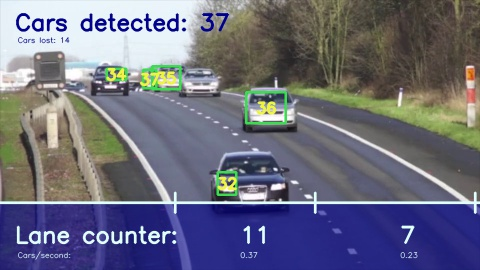

In [105]:
for filename in sorted(glob.glob(os.path.join(os.path.abspath(OUTPUT_DIR),
                                              'output-frame_*.jpg'))):
    frame = cv2.imread(filename)
    clear_output(wait=True)
    rows, columns, _channels = frame.shape
    frame = cv2.resize(frame, (int(columns/2), int(rows/2)))  # shrink it
    _ret, jpg = cv2.imencode('.jpg', frame)
    display(Image(data=jpg))

In [106]:
!ffmpeg -y -r 60 -f image2 -i output/output-frame_%05d.jpg -vcodec libx264 -crf 25  -pix_fmt yuvj420p wml.mp4

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda/envs/Python-3.8-CUDA --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55

In [107]:
mp4 = open("wml.mp4", "rb").read()
dataURL = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=800 controls>
      <source src="%s" type="video/mp4">
</video>
""" % dataURL)